This notebook brings the different components of the applications together


*   Digit recognition (predictive AI)
*   Results' ouput as text (generative AI)
*   Results' output as coordinate + temperature (generative AI - agent+tools)
*   Results' output as map (geographic information systems)

# Chapter 1: Application

In [ ]:
!pip install -qU langchain langgraph langsmith langchain-openai langchain_community pyowm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.2/148.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB

In [ ]:
import os
import getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

In [ ]:
# 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
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = ""

In [ ]:
# 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
if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your TavilySearch API key: ")

Enter your TavilySearch API key: ··········


In [ ]:
# 73c2ab70e974c13a080c5133cc544990
os.environ["OPENWEATHERMAP_API_KEY"] = ""

In [ ]:
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities import OpenWeatherMapAPIWrapper

@tool
def get_weather(location: str):
    """Call to get the current weather."""
    # Documentation: https://python.langchain.com/docs/integrations/tools/openweathermap/
    weather = OpenWeatherMapAPIWrapper()
    weather_data = weather.run(location)
    print(weather_data)
    return weather_data

search_engine = TavilySearchResults(max_results=2)

tools = [search_engine, get_weather]



from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools) # the large language model should come up with arguments to be passed to one of the tools


# Example adapted from https://langchain-ai.github.io/langgraph/how-tos/tool-calling/#react-agent

# https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

app = workflow.compile()

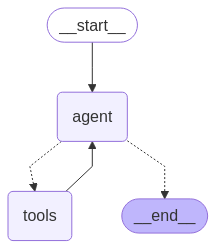

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Example of map using geojson, folium and gradio

In [ ]:
# This code was generated from ChatGPT and then modified to read a satisfactory execution
import folium
import gradio as gr
import json

# Sample GeoJSON data (you can replace this with your own)
geojson_sample = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {"name": "Sample Polygon"},
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [-100.0, 40.0],
                        [-105.0, 45.0],
                        [-110.0, 40.0],
                        [-100.0, 40.0]
                    ]
                ]
            }
        }
    ]
}

def generate_map(geojson_data_str):
    # Parse GeoJSON string
    try:
        geojson_data = json.loads(geojson_data_str)
    except json.JSONDecodeError:
        return "Invalid GeoJSON input."

    # Create a Folium map
    m = folium.Map(location=[40, -100], zoom_start=4)

    # Add GeoJSON layer
    folium.GeoJson(geojson_data, name="geojson").add_to(m)


    return m._repr_html_()

# Gradio interface
interface = gr.Interface(
    fn=generate_map,
    inputs=gr.Textbox(label="Enter GeoJSON Data", lines=10, placeholder="Paste your GeoJSON here..."),
    outputs=gr.HTML(label="Map Output")
)

if __name__ == "__main__":
    interface.launch(debug=True)

Image input + Digit recognition + Verbalization as text + Display on a map

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

import numpy as np
from scipy.spatial.distance import cdist

class GraphNet(nn.Module):
    def __init__(self, img_size=28, pred_edge=False):
        super(GraphNet, self).__init__()
        self.pred_edge = pred_edge
        N = img_size * img_size
        self.fc = nn.Linear(N, 10, bias=False)
        if pred_edge:
            col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
            coord = np.stack((col, row), axis=2).reshape(-1, 2)
            coord = (coord - np.mean(coord, axis=0)) / (np.std(coord, axis=0) + 1e-5)
            coord = torch.from_numpy(coord).float()  # 784,2
            coord = torch.cat((coord.unsqueeze(0).repeat(N, 1,  1),
                                    coord.unsqueeze(1).repeat(1, N, 1)), dim=2)
            #coord = torch.abs(coord[:, :, [0, 1]] - coord[:, :, [2, 3]])
            self.pred_edge_fc = nn.Sequential(nn.Linear(4, 64),
                                              nn.ReLU(),
                                              nn.Linear(64, 1),
                                              nn.Tanh())
            self.register_buffer('coord', coord)
        else:
            # precompute adjacency matrix before training
            A = self.precompute_adjacency_images(img_size)
            self.register_buffer('A', A)


    @staticmethod
    def precompute_adjacency_images(img_size):
        col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
        coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size
        dist = cdist(coord, coord)
        sigma = 0.05 * np.pi

        A = np.exp(- dist / sigma ** 2)

        A[A < 0.01] = 0
        A = torch.from_numpy(A).float()

        # Normalization as per (Kipf & Welling, ICLR 2017)
        D = A.sum(1)  # nodes degree (N,)
        D_hat = (D + 1e-5) ** (-0.5)
        A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1)  # N,N

        # Some additional trick I found to be useful
        A_hat[A_hat > 0.0001] = A_hat[A_hat > 0.0001] - 0.2

        #print(A_hat[:10, :10])
        return A_hat

    def forward(self, x):
        B = x.size(0)
        if self.pred_edge:
            self.A = self.pred_edge_fc(self.coord).squeeze()

        avg_neighbor_features = (torch.bmm(self.A.unsqueeze(0).expand(B, -1, -1),
                                 x.view(B, -1, 1)).view(B, -1))
        return self.fc(avg_neighbor_features)

In [ ]:
import folium


def verbalize (outcome):
  prompt = """

  You are an assistant specialized into turning information from a json input into some nice text.

  The first value stands for a predicted class and the second value stands for the probability.

  Turn the following input into a nice text:

  """
  user_input = prompt + str(outcome)

  result = app.invoke({"messages": [("human", user_input)]})

  return result["messages"][-1].content

def show_on_map (outcome):

  prompt = """

  You are an assistant specialized into returning information about the closest cities to the city of Dresden, Germany.

  The output should be formatted as geojson. Return their coordinates, the distance in km and the temperature values of these cities.

  Do not add any additional text to the output. The ouput should start and finish with {} as expected of a properly-formatted geojson.

  Do not add ```json.

  Key for cities: 'city'

  Key for distance: 'distance_km'

  Key for temperature: 'temperature_c'

  Number of cities:

  """
  print("*** Current number of cities: ", list(outcome.keys())[0])
  user_input = prompt + str(list(outcome.keys())[0]) # https://stackoverflow.com/a/77694283

  result = app.invoke({"messages": [("human", user_input)]})
  print("***LLM-generated coordinates: ", result["messages"][-1].content)

  data = json.loads(result["messages"][-1].content)
  print("***Data for map: ", data)
  m = folium.Map(location=(51.05, 13.73)) # for alternatives, see https://leafmap.org/get-started/

  folium.GeoJson(data,
                tooltip=folium.GeoJsonTooltip(fields=["city", "distance_km", "temperature_c"]),
                popup=folium.GeoJsonPopup(fields=["city", "distance_km", "temperature_c"])
                ).add_to(m)

  folium.Marker(
      location=[51.049259, 13.73836],
      tooltip="Dresden",
      popup="Dresden",
      icon=folium.Icon(color="green"),
  ).add_to(m)

  return m._repr_html_()

In [ ]:
import cv2
from torchvision import transforms
from torchvision.transforms import v2
import numpy as np
import gradio as gr
from PIL import Image
import json


## Function definition
def transform_image(image):
  transf = v2.Compose([
              transforms.Grayscale(num_output_channels=1),
              transforms.Resize((28, 28)),
              transforms.ToTensor(),
              transforms.Normalize((0.1307,), (0.3081,))
               ])

  return transf(image)

def predict_digit(image, trained_model):

  outputs = trained_model(image)
 # print(outputs)

  probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
 # print(probabilities)

  # https://www.youtube.com/watch?v=a8aS3ZYlzDM
  values, indices = torch.topk(probabilities, 5)

  labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

  return {labels[i]:v.item() for i, v in zip(indices, values)}

def recognize_digit(image):
  if image is None:
    return None, "No Prediction", "Please upload an image.", None # Default values for no image
  else:
    pil_img = Image.fromarray(image["composite"])
    inv = transforms.functional.invert(pil_img)
    outcome = predict_digit(transform_image(inv), trained_model)
    print("** Digit recognition outcome: ", outcome)
    print("** Type of the outcome: ", type(outcome))
    outcome_as_text = verbalize (outcome)
    outcome_on_map = show_on_map (outcome)
    return image["composite"], outcome, outcome_as_text, outcome_on_map


## Function use

trained_model = GraphNet()
checkpoint_path = '/content/my_mnist_model_graph.pt'

# load the weights of the trained model
checkpoint = torch.load(checkpoint_path, weights_only=True)
trained_model.load_state_dict(checkpoint)


with gr.Blocks() as demo:
    with gr.Row(equal_height=True):
        im_input = gr.ImageEditor(type="numpy", image_mode="L", crop_size="1:1", label="Input Image Component") # Sketchpad, ImageEditor
        im_preview = gr.Image(label="Output Image Component")
        predicted_label = gr.Label(label="Class predictions")
    with gr.Row():
        text_box = gr.TextArea(label ="Predictions as text")
    with gr.Row():
        map_component = gr.HTML(label="Map Output")

    im_input.upload(recognize_digit, outputs=[im_preview, predicted_label, text_box, map_component], inputs=im_input, show_progress="full")
    #im_input.change(recognize_digit, outputs=[im_preview, predicted_label, text_box, map_component], inputs=im_input, show_progress="full")

demo.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://47f39d052d4f6350b4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


** Digit recognition outcome:  {'4': 0.5915224552154541, '9': 0.18638725578784943, '6': 0.12957772612571716, '5': 0.04414290934801102, '7': 0.014780444093048573}
** Type of the outcome:  <class 'dict'>
*** Current number of cities:  4
In Leipzig, Germany, the current weather is as follows:
Detailed status: overcast clouds
Wind speed: 5.66 m/s, direction: 360°
Humidity: 87%
Temperature: 
  - Current: 10.07°C
  - High: 10.11°C
  - Low: 9.49°C
  - Feels like: 9.4°C
Rain: {}
Heat index: None
Cloud cover: 100%
In Halle, Germany, the current weather is as follows:
Detailed status: overcast clouds
Wind speed: 5.66 m/s, direction: 360°
Humidity: 84%
Temperature: 
  - Current: 10.01°C
  - High: 10.46°C
  - Low: 9.39°C
  - Feels like: 9.26°C
Rain: {}
Heat index: None
Cloud cover: 100%
In Jena, Germany, the current weather is as follows:
Detailed status: overcast clouds
Wind speed: 1.34 m/s, direction: 16°
Humidity: 96%
Temperature: 
  - Current: 7.93°C
  - High: 8.75°C
  - Low: 7.53°C
  - Feels 

Example of correct geojson

```javascript
{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {
        "city": "Chemnitz",
        "distance_km": 82,
        "temperature_c": 10.37
      },
      "geometry": {
        "type": "Point",
        "coordinates": [12.9222, 50.8278]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Leipzig",
        "distance_km": 100,
        "temperature_c": 16.06
      },
      "geometry": {
        "type": "Point",
        "coordinates": [12.3731, 51.3397]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Meissen",
        "distance_km": 25,
        "temperature_c": 12.75
      },
      "geometry": {
        "type": "Point",
        "coordinates": [13.4809, 51.1605]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Cottbus",
        "distance_km": 113,
        "temperature_c": 17.01
      },
      "geometry": {
        "type": "Point",
        "coordinates": [14.3423, 51.7592]
      }
    }
  ]
}
```

# Chapter 2: DeepSeek

This is a simple example to text map (code) generation using the Deepseek model

In [ ]:
# Please install OpenAI SDK first: `pip3 install openai`

from openai import OpenAI

client = OpenAI(api_key="", base_url="https://api.deepseek.com")

response = client.chat.completions.create(
    model="deepseek-chat",
    messages=[
        {"role": "system", "content": "You are a helpful assistant. Write a code in python to show a map using folium. The map should be centered on Dresden, Germany"},
        {"role": "user", "content": "Hello"},
    ],
    stream=False
)

print(response.choices[0].message.content)

In [ ]:
import folium

# Coordinates for Dresden, Germany
dresden_coords = [51.0504, 13.7373]

# Create a map centered on Dresden
dresden_map = folium.Map(location=dresden_coords, zoom_start=13)

# Add a marker for Dresden
folium.Marker(
    location=dresden_coords,
    popup="Dresden, Germany",
    icon=folium.Icon(color="red")
).add_to(dresden_map)

# Display the map
dresden_map

In [ ]:
import folium

# Create map with more features
dresden_map = folium.Map(
    location=[51.0504, 13.7373],
    zoom_start=12,
    #tiles='Stamen Terrain',
    control_scale=True
)

# Add multiple markers
landmarks = {
    'Frauenkirche': [51.0518, 13.7416],
    'Zwinger Palace': [51.0531, 13.7339],
    'Semperoper': [51.0542, 13.7353]
}

for name, coords in landmarks.items():
    folium.Marker(
        location=coords,
        popup=name,
        icon=folium.Icon(color='blue')
    ).add_to(dresden_map)

# Add a circle around city center
folium.Circle(
    location=[51.0504, 13.7373],
    radius=2000,
    color='green',
    fill=True,
    fill_color='green',
    fill_opacity=0.2,
    popup='Central Dresden'
).add_to(dresden_map)

# Add layer control
folium.LayerControl().add_to(dresden_map)

#dresden_map.save('dresden_landmarks.html')
dresden_map